In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from cntxt import rom_am
from rom_am import ROM
import matplotlib.pyplot as plt
import scipy.interpolate as si

## Loading Data from simulation results

In [2]:
pist_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_fixed_dt.txt")
nnt = pist_pressure.shape[0]
fl_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_field_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho_e = np.loadtxt("../DATA/Fsi_Results/results_rho_e_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho_v = np.loadtxt("../DATA/Fsi_Results/results_rho_v_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_velocity_end = np.loadtxt("../DATA/Fsi_Results/results_v_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho = np.loadtxt("../DATA/Fsi_Results/results_rho_fixed_dt.txt").reshape((-1,nnt), order = 'F')
delta_t = np.loadtxt("../DATA/Fsi_Results/results_Delta_T_fixed_dt.txt")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1

In [2]:
pist_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres.txt")
nnt = pist_pressure.shape[0]
fl_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_field.txt").reshape((-1,nnt), order = 'F')
fl_rho_e = np.loadtxt("../DATA/Fsi_Results/results_rho_e.txt").reshape((-1,nnt), order = 'F')
fl_rho_v = np.loadtxt("../DATA/Fsi_Results/results_rho_v.txt").reshape((-1,nnt), order = 'F')
fl_velocity_end = np.loadtxt("../DATA/Fsi_Results/results_v.txt").reshape((-1,nnt), order = 'F')
fl_rho = np.loadtxt("../DATA/Fsi_Results/results_rho.txt").reshape((-1,nnt), order = 'F')
moving_mesh = np.loadtxt("../DATA/Fsi_Results/results_mesh.txt").reshape((-1,nnt), order = 'F')
delta_t = np.loadtxt("../DATA/Fsi_Results/results_Delta_T.txt")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1
L0 = 1.2

## ----------------------------------------------------------------------------------------------------------------------

## POD Reconstruction

In [3]:
# Training data
X = fl_pressure

In [4]:
pod = ROM(rom="pod")
pod.decompose(X, alg="svd",)

In [5]:
rank = 4
rec_X = pod.approximate(rank)

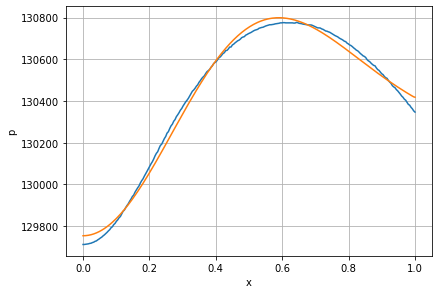

In [6]:
domain = np.linspace(0, L, nx)

plt.plot(domain, X[: , -1]);
plt.plot(domain, rec_X[: ,  -1]);
plt.grid();
plt.tight_layout();

plt.xlabel("x");
plt.ylabel("p");

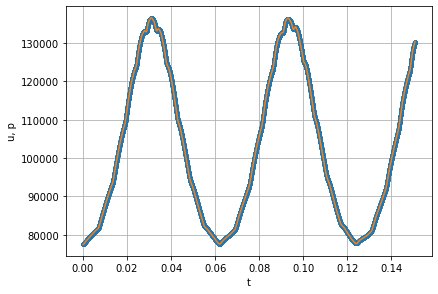

In [7]:
plt.plot(t, X[-1, :], '.');
plt.plot(t, rec_X[-1, :]);
plt.grid();
plt.tight_layout();

plt.xlabel("t");
plt.ylabel("u, p");

## ----------------------------------------------------------------------------------------------------------------------

## DMD Reduction

**Interpolate to fixed time intervals**

In [8]:
# Choose number of equally spaced timesteps 
ntt = 200
dt = t[-1] / ntt


# Interpolating original data to the new timesteps
target_t = np.linspace(t[0], t[-1], ntt)
target_fl_pressure = si.griddata(t, fl_pressure.T, target_t, method='nearest').T
target_fl_velocity = si.griddata(t, fl_velocity.T, target_t, method='nearest').T
target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t, method='nearest').T

**Probe data for training**

In [9]:
# Choose coefficient of time interval(of data) chosen for training
Coeff = .5

# Training data (considering moving mesh)
XY_DATA = np.concatenate((target_fl_m_mesh[:, :int(
    ntt * Coeff)], target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)]))
X = XY_DATA[:, :-1]
Y = XY_DATA[:, 1::]

# Training data (Disregarding moving mesh)
XY_DATA_2 = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)]))
X2 = XY_DATA_2[:, :-1]
Y2 = XY_DATA_2[:, 1::]

**DMD reduction on velocity**

In [10]:
rank = 0
dmd = ROM("dmd")
dmd.decompose(X, Y, dt = dt, rank = rank, sorting="abs")

In [11]:
rank = 0
dmd2 = ROM("dmd")
dmd2.decompose(X2, Y2, dt = dt, rank = rank, sorting="abs")

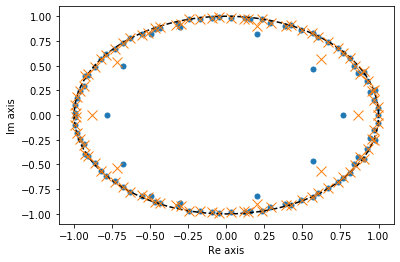

In [12]:
plt.plot(np.real(dmd.lambd), np.imag(dmd.lambd), '.', markersize = 10);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

plt.plot(np.real(dmd2.lambd), np.imag(dmd2.lambd), 'x', markersize = 10);

## Reconstructing X

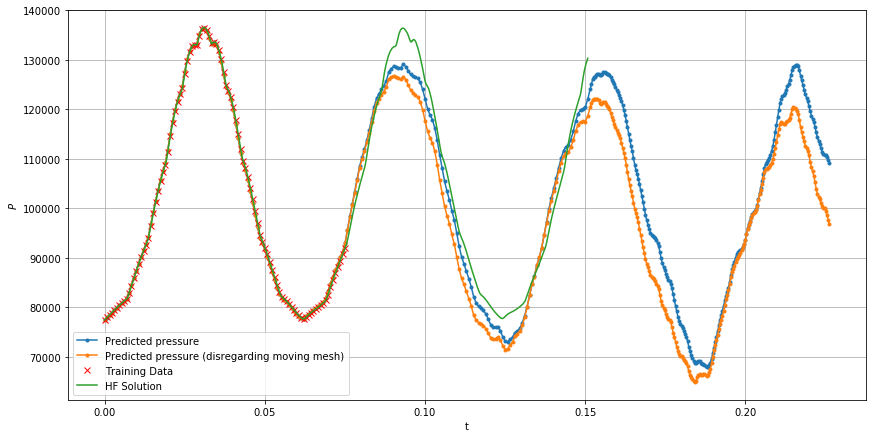

In [91]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1

fig = plt.figure(figsize = (12, 6))
prediction_t = np.concatenate((target_t, np.linspace(target_t[-1] + dt, 1.5 * target_t[-1], int(ntt))))
predicted_X = np.real(dmd.dmd_predict(prediction_t, t1 = t[0]))
predicted_X2 = np.real(dmd2.dmd_predict(prediction_t, t1 = t[0]))

predicted_mesh = predicted_X[:nx, :]
predicted_pressure = predicted_X[nx : 2 * nx, :]
predicted_pressure_nomesh = predicted_X2[:nx, :]

plt.plot(prediction_t, predicted_pressure[-x_n, :], '.-', label = "Predicted pressure")
plt.plot(prediction_t, predicted_pressure_nomesh[-x_n, :], '.-', label = "Predicted pressure (disregarding moving mesh)")
plt.plot(target_t[: int(ntt * Coeff)], target_fl_pressure[-x_n, :int(ntt * Coeff)], 'xr', label = "Training Data");


plt.plot(t, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();

plt.xlabel("t");
plt.ylabel("$P$");

## Display

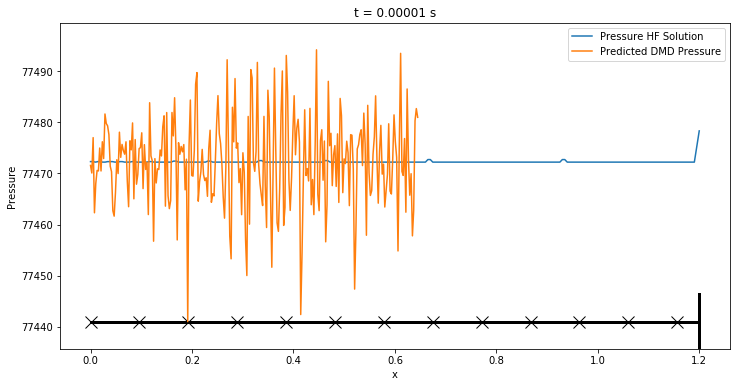

In [107]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize = (12, 6))

x = target_fl_m_mesh[:, 0]
line, = ax.plot(x, target_fl_pressure[:, 0], label = "Pressure HF Solution");
thresh = target_fl_pressure[:, 0].min()*.9
line2, = ax.plot(x, thresh * np.ones(x.shape[0]), 'k', linewidth = 3,);
line3, = ax.plot(target_fl_m_mesh[-1, 0] * np.ones(50), np.linspace(thresh * .96, thresh * 1.04, 50), 'k', linewidth = 3,);
line4, = ax.plot(x[::20], thresh * np.ones(x[::20].shape[0]), 'kx', linewidth = 3, markersize = 12);
line5, = ax.plot(x, predicted_pressure[:, 0], label = "Predicted DMD Pressure");
plt.xlabel("x")
plt.ylabel("Pressure")

def animate(i):
    
    plt.title(f"t = {target_t[i]:.5f} s");
    
    length = max(target_fl_pressure[:, i].max(), predicted_pressure[:, i].max())  - min(target_fl_pressure[:, i].min(), predicted_pressure[:, i].min())
    thresh = min(target_fl_pressure[:, i].min(), predicted_pressure[:, i].min()) - .1 * length

    ax.set_ylim(top = max(target_fl_pressure[:, i].max(), predicted_pressure[:, i].max()) + .1 * length, bottom = thresh);

    line.set_xdata(target_fl_m_mesh[:, i])  ;
    line.set_ydata(target_fl_pressure[:, i]) ;
    
    line2.set_xdata(target_fl_m_mesh[:, i])  ;
    line2.set_ydata(thresh + .1 * length) ;
    
    line3.set_xdata(target_fl_m_mesh[-1, i]) ;
    line3.set_ydata(np.linspace(thresh, thresh + length *  .2, 50));
    
    line4.set_xdata(target_fl_m_mesh[:, i][::20]) ; 
    line4.set_ydata(thresh + .1 * length);
    
    line5.set_xdata(predicted_mesh[:, i])  ;
    line5.set_ydata(predicted_pressure[:, i]);
    return line, line2, line3

plt.legend();
ani = animation.FuncAnimation(
    fig, animate, interval=110, blit=False, save_count=target_fl_m_mesh.shape[1]);

# save the animation
ani.save("Pressure_in_Fluid.mp4")

# plt.grid()

## Errors

In [188]:
def sample_data(ntt):
    # Choose number of equally spaced timesteps 
    dt = t[-1] / ntt


    # Interpolating original data to the new timesteps
    target_t = np.linspace(t[0], t[-1], ntt)
    target_fl_pressure = si.griddata(t, fl_pressure.T, target_t,).T
    target_fl_velocity = si.griddata(t, fl_velocity.T, target_t,).T
    target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t,).T
    
    return dt, target_t, target_fl_m_mesh, target_fl_pressure, target_fl_velocity
    
def create_DATA(Coeff):
    # Training data (considering moving mesh)
    XY_DATA = np.concatenate((target_fl_m_mesh[:, :int(
        ntt * Coeff)], target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)]))
    X = XY_DATA[:, :-1]
    Y = XY_DATA[:, 1::]
    
    return X, Y


def predict_by_DMD(X, Y):
    
    rank = 20
    dmd = ROM("dmd")
    dmd.decompose(X, Y, dt = dt, rank = rank, sorting="abs")
    
    prediction_t = t
    predicted_X = np.real(dmd.dmd_predict(prediction_t, t1 = t[0]))
    
    predicted_mesh = predicted_X[:nx, :]
    predicted_pressure = predicted_X[nx : 2 * nx, :]
    predicted_velocity = predicted_X[2 * nx ::, :]

    return predicted_mesh, predicted_pressure, predicted_velocity

def compute_error(predicted, reference):
    
    err = ((predicted - reference)**2).mean()
    
    return err

In [189]:
ntt_list = [80, 100, 200, ]
err = np.zeros(len(ntt_list))

for i in range(len(ntt_list)):
    dt, target_t, target_fl_m_mesh, target_fl_pressure, target_fl_velocity = sample_data(ntt_list[i])
    X, Y = create_DATA(.6)
    predicted_mesh, predicted_pressure, predicted_velocity = predict_by_DMD(X, Y)
    err[i] = compute_error(predicted_velocity, fl_velocity)

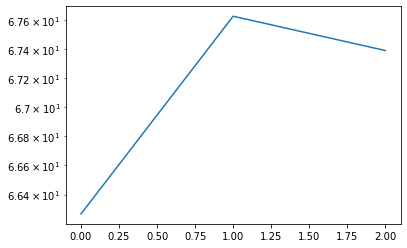

In [190]:
plt.semilogy(err, );